<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.datasets import boston_housing
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV

In [2]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
def model_structure():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mse', 'mae'])
    return model

In [4]:
model = KerasRegressor(build_fn=model_structure, verbose=0)

In [5]:
grid_params = {'batch_size': [10, 20, 40, 60, 80, 100],
                  'epochs': [20,50,100]}

grid = GridSearchCV(estimator=model, param_grid=grid_params, n_jobs=6)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}") 

/home/j_m/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/j_m/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: -11.793835601299117 using {'batch_size': 10, 'epochs': 50}
Means: -16.09443866055791, Stdev: 3.065640012993628 with: {'batch_size': 10, 'epochs': 20}
Means: -11.793835601299117, Stdev: 2.773117878126645 with: {'batch_size': 10, 'epochs': 50}
Means: -12.124990610202941, Stdev: 2.934892038495527 with: {'batch_size': 10, 'epochs': 100}
Means: -17.390336209004467, Stdev: 3.9657931251372203 with: {'batch_size': 20, 'epochs': 20}
Means: -14.338109790688694, Stdev: 4.968053624547526 with: {'batch_size': 20, 'epochs': 50}
Means: -11.973049737439297, Stdev: 3.6644838253923955 with: {'batch_size': 20, 'epochs': 100}
Means: -20.063210107312344, Stdev: 5.973770164149739 with: {'batch_size': 40, 'epochs': 20}
Means: -14.511469527046279, Stdev: 1.9951885402322558 with: {'batch_size': 40, 'epochs': 50}
Means: -13.368844676725935, Stdev: 1.7703436610146182 with: {'batch_size': 40, 'epochs': 100}
Means: -26.592097591645647, Stdev: 10.92038890501889 with: {'batch_size': 60, 'epochs': 20}
Means: -1

In [6]:
pred = grid_result.predict(X_test)
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
mse, mae

(19.886206795335266, 2.9848311424255374)

In [9]:
history = model.fit(X_train, y_train, validation_split=0.15, epochs=100, batch_size=10, verbose=1)

Train on 343 samples, validate on 61 samples
Epoch 1/100
343/343 [==============================] - 1s 2ms/sample - loss: 402.4059 - mse: 402.4058 - mae: 17.5013 - val_loss: 285.8745 - val_mse: 285.8745 - val_mae: 14.2246
Epoch 2/100
343/343 [==============================] - 0s 210us/sample - loss: 121.2744 - mse: 121.2744 - mae: 8.3069 - val_loss: 88.0289 - val_mse: 88.0289 - val_mae: 6.8244
Epoch 3/100
343/343 [==============================] - 0s 218us/sample - loss: 61.9851 - mse: 61.9851 - mae: 5.6964 - val_loss: 47.6506 - val_mse: 47.6506 - val_mae: 5.0495
Epoch 4/100
343/343 [==============================] - 0s 214us/sample - loss: 42.9380 - mse: 42.9380 - mae: 4.7284 - val_loss: 32.3369 - val_mse: 32.3369 - val_mae: 4.0968
Epoch 5/100
343/343 [==============================] - 0s 209us/sample - loss: 34.0459 - mse: 34.0459 - mae: 4.1530 - val_loss: 21.9833 - val_mse: 21.9833 - val_mae: 3.4727
Epoch 6/100
343/343 [==============================] - 0s 215us/sample - loss: 30.81

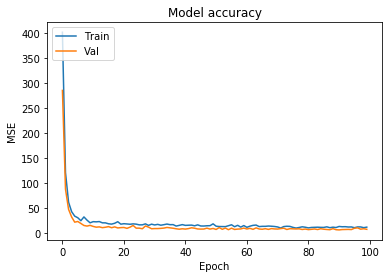

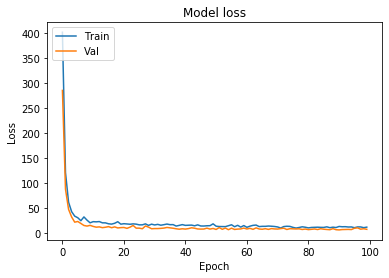

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model accuracy')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [23]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [24]:
epochs = 20
num_classes = 10
batch_size = 64

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [22]:
mnist_model = Sequential()

# Input => Hidden
mnist_model.add(Dense(16, input_dim=784, activation='relu'))
# Hidden
mnist_model.add(Dense(16, activation='relu'))
# Hidden
mnist_model.add(Dense(16, activation='relu'))
# Hidden
mnist_model.add(Dense(16, activation='relu'))
# Output
mnist_model.add(Dense(10,activation='softmax'))

#Compile
mnist_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

mnist_model.summary()


NameError: name 'num_classes' is not defined

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.